# Loading the data

In [84]:
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

def extract_smu_ids(countries):
    countries = world[world["NAME"].isin(countries)]

    # ensure CRS match
    countries = countries.to_crs(rds.rio.crs)

    # clip raster to Algeria + Tunisia
    clipped = rds.rio.clip(countries.geometry, from_disk=True)
    # print("Clipping done.")
    transform = clipped.rio.transform()

    # Get pixel indices (ignore band dimension)
    rows, cols = np.indices(clipped.shape[1:])

    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    # print("Coordinate extraction done.")
    lons = np.array(xs).flatten()
    lats = np.array(ys).flatten()

    # Flatten raster values
    smu_ids = clipped.values.flatten()

    # Remove NaN values
    mask = ~np.isnan(smu_ids)
    # print("NaN removal done.")

    df = pd.DataFrame({
        "lon": lons[mask],
        "lat": lats[mask],
        "HWSD2_SMU_ID": smu_ids[mask].astype(int)
    })
    # print("DataFrame creation done.")
    return df, clipped

def filter_smu_layers(smu_ids, layers):
    # Filter to selected SMU_IDs
    layers_filtered = layers[layers["HWSD2_SMU_ID"].isin(smu_ids["HWSD2_SMU_ID"])]
    return layers_filtered


mdb_path = r"../local_dataset/raw/soil/HWSD2.mdb"
conn_str = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    f"DBQ={mdb_path};"
)
conn = pyodbc.connect(conn_str)

smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
world = gpd.read_file(r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp")
raster_path = r"../local_dataset/raw/soil/HWSD2.bil"
rds = rioxarray.open_rasterio(raster_path)


smu_ids, clipped_rds = extract_smu_ids(["Algeria", "Tunisia"])

layers = filter_smu_layers(smu_ids, layers)

layers = layers[layers["LAYER"] == "D1"]
useful_columns = [
    "HWSD2_SMU_ID", "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND",
]
layers = layers[useful_columns]
all_cols = layers.drop(columns=["HWSD2_SMU_ID"])
all_cols["TEXTURE_SOTER"] = all_cols["TEXTURE_SOTER"].replace(["-"], np.nan) # replace invalid string entries with NaN
numeric_cols_names = all_cols.select_dtypes(include='number').columns
all_cols[numeric_cols_names] = all_cols[numeric_cols_names].mask(all_cols[numeric_cols_names] < 0) # replace invalid negative values with NaN

# clipped_rds = clipped_rds.squeeze("band", drop=True)
# clipped_rds.plot(cmap="YlOrBr", robust=True, figsize=(8, 6))
# plt.title("Soil Property Map")
# plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_10340\2247709408.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_10340\2247709408.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)


# Analysis part

In [85]:
import math

print(f"Shape {all_cols.shape}")
print("=== Data types per column ===")
print(all_cols.dtypes)

Shape (858, 22)
=== Data types per column ===
COARSE           float64
SAND             float64
SILT             float64
CLAY             float64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL         float64
CEC_CLAY         float64
CEC_EFF          float64
TEB              float64
BSAT             float64
ALUM_SAT         float64
ESP              float64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND        float64
dtype: object


# Missing and erroneous values in each column 

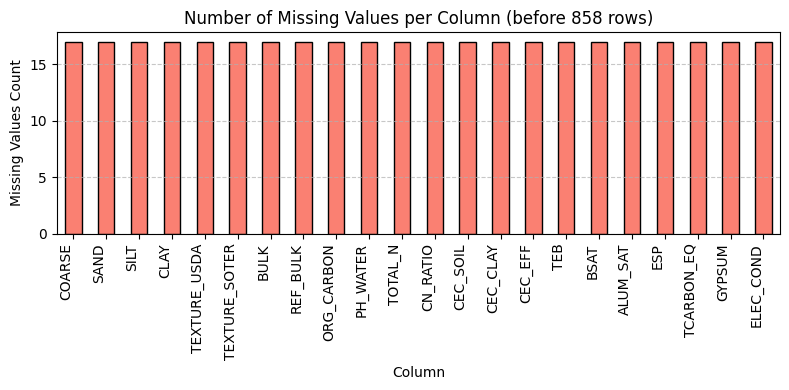

Pandas(Index=79087, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TEXTURE_SOTER=nan, BULK=nan, REF_BULK=nan, ORG_CARBON=nan, PH_WATER=nan, TOTAL_N=nan, CN_RATIO=nan, CEC_SOIL=nan, CEC_CLAY=nan, CEC_EFF=nan, TEB=nan, BSAT=nan, ALUM_SAT=nan, ESP=nan, TCARBON_EQ=nan, GYPSUM=nan, ELEC_COND=nan)
Pandas(Index=79089, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TEXTURE_SOTER=nan, BULK=nan, REF_BULK=nan, ORG_CARBON=nan, PH_WATER=nan, TOTAL_N=nan, CN_RATIO=nan, CEC_SOIL=nan, CEC_CLAY=nan, CEC_EFF=nan, TEB=nan, BSAT=nan, ALUM_SAT=nan, ESP=nan, TCARBON_EQ=nan, GYPSUM=nan, ELEC_COND=nan)
Pandas(Index=79093, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TEXTURE_SOTER=nan, BULK=nan, REF_BULK=nan, ORG_CARBON=nan, PH_WATER=nan, TOTAL_N=nan, CN_RATIO=nan, CEC_SOIL=nan, CEC_CLAY=nan, CEC_EFF=nan, TEB=nan, BSAT=nan, ALUM_SAT=nan, ESP=nan, TCARBON_EQ=nan, GYPSUM=nan, ELEC_COND=nan)
Pandas(Index=79094, COARSE=nan, SAND=nan, SILT=nan, CLAY=nan, TEXTURE_USDA=nan, TE

In [86]:

def plot_missing_values(missing_values_count, number_of_rows):
    # number_of_rows = all_cols.shape[0]
    plt.figure(figsize=(8,4))
    missing_values_count.plot(kind='bar', color='salmon', edgecolor='black')

    plt.title(f"Number of Missing Values per Column (before {number_of_rows} rows)")
    plt.ylabel("Missing Values Count")
    plt.xlabel("Column")
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


missing_values_count = all_cols.isnull().sum()
plot_missing_values(missing_values_count, all_cols.shape[0])
missing_values_rows = all_cols[all_cols.isnull().any(axis=1)]
for row in missing_values_rows.itertuples():
    print(row)


# Fixing Missing values 

Found 600 neighbors for index 79087
Found 575 neighbors for index 79089
Found 600 neighbors for index 79093
Found 600 neighbors for index 79094
Found 600 neighbors for index 79098


C:\Users\pc\AppData\Local\Temp\ipykernel_10340\253328069.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  default_result_row[numeric_cols_names] = all_cols[numeric_cols_names].median()
C:\Users\pc\AppData\Local\Temp\ipykernel_10340\253328069.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  default_result_row[string_cols_names] = all_cols[string_cols_names].mode().iloc[0]


Found 575 neighbors for index 79103
Found 600 neighbors for index 275373
Found 600 neighbors for index 275379
Found 600 neighbors for index 275380
Found 600 neighbors for index 275384
Found 600 neighbors for index 275385
Found 600 neighbors for index 275388
Found 575 neighbors for index 275389
Found 600 neighbors for index 291432
Found 600 neighbors for index 291460
Found 625 neighbors for index 299705
Found 600 neighbors for index 299775
COARSE           0
SAND             0
SILT             0
CLAY             0
TEXTURE_USDA     0
TEXTURE_SOTER    0
BULK             0
REF_BULK         0
ORG_CARBON       0
PH_WATER         0
TOTAL_N          0
CN_RATIO         0
CEC_SOIL         0
CEC_CLAY         0
CEC_EFF          0
TEB              0
BSAT             0
ALUM_SAT         0
ESP              0
TCARBON_EQ       0
GYPSUM           0
ELEC_COND        0
dtype: int64


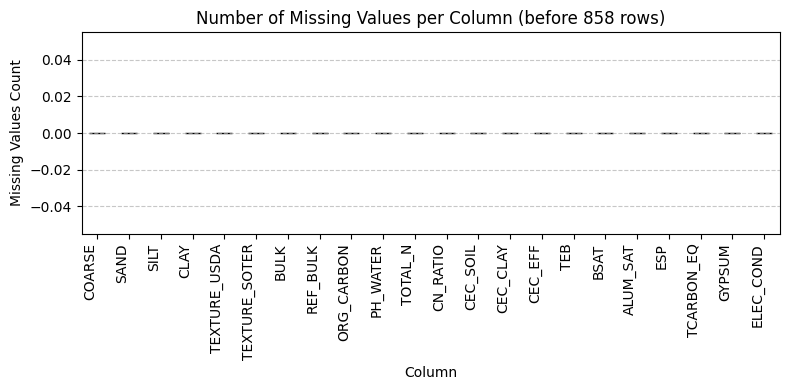

In [87]:
def fix_missing_values(index, defualt_result_row):
    radius = 0.1
    missing_smu_id = smu_ids.loc[index]
    lat_min = missing_smu_id["lat"] - radius
    lat_max = missing_smu_id["lat"] + radius
    lon_min = missing_smu_id["lon"] - radius
    lon_max = missing_smu_id["lon"] + radius

    neighbors_smu_ids = smu_ids[
        (smu_ids["lat"] >= lat_min) & (smu_ids["lat"] <= lat_max) &
        (smu_ids["lon"] >= lon_min) & (smu_ids["lon"] <= lon_max)
    ]
    print(f"Found {len(neighbors_smu_ids)} neighbors for index {index}")

    neighbors_layers = layers[
        layers["HWSD2_SMU_ID"].isin(neighbors_smu_ids["HWSD2_SMU_ID"]) &
        (layers.index != index)  # exclude the row itself
    ].drop(columns=["HWSD2_SMU_ID"])

    if neighbors_layers.empty:
        return default_result_row

    numeric_cols = neighbors_layers.select_dtypes(include=['number']).mean().to_frame().T
    string_cols = neighbors_layers.select_dtypes(include=['object']).mode().iloc[0].to_frame().T
    result_row = pd.concat([numeric_cols, string_cols], axis=1)[neighbors_layers.columns]
    return result_row

missing_values_indices = missing_values_rows.index

default_result_row = pd.DataFrame([ [np.nan]*len(all_cols.columns) ], columns=all_cols.columns)
numeric_cols_names = all_cols.select_dtypes(include='number').columns
string_cols_names = all_cols.select_dtypes(include='object').columns
default_result_row[numeric_cols_names] = all_cols[numeric_cols_names].median()
default_result_row[string_cols_names] = all_cols[string_cols_names].mode().iloc[0]
# print(default_result_row)

for i, index in enumerate(missing_values_indices):
    result_row = fix_missing_values(index, default_result_row)
    all_cols.loc[index] = result_row.iloc[0]
print(all_cols.isnull().sum())

missing_values_count = all_cols.isnull().sum()
plot_missing_values(missing_values_count, all_cols.shape[0])

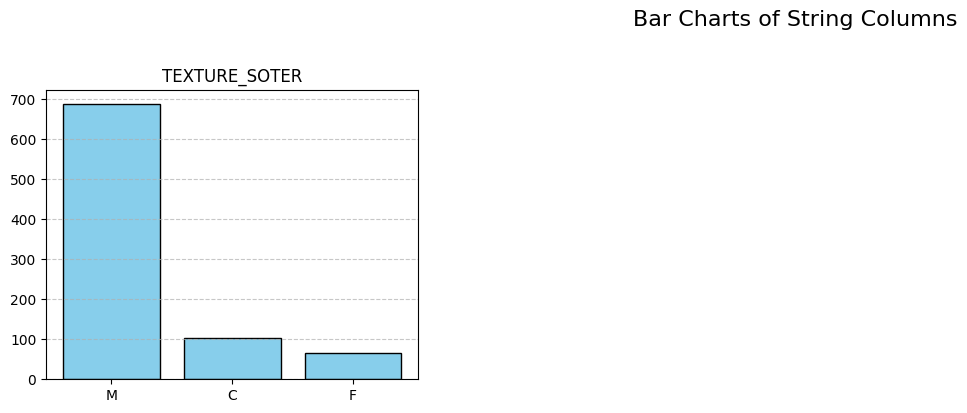

In [88]:
string_cols = all_cols.select_dtypes(include=['object'])
# plot bar charts for categorical columns
cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_bar_charts(string_cols):
    n = len(string_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Bar Charts of String Columns", fontsize=16, y=1.02)
    for i, col in enumerate(string_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        value_counts = string_cols[col].value_counts()
        plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_bar_charts(string_cols)


# Univariate Analysis

In [89]:
print("=== Univariate Analysis === ")
print(f"=== Mean ===\n{numeric_cols.mean()}")
print(f"===  Standard Deviation ===\n{numeric_cols.std()}")
print(f"===  Minimum ===\n{numeric_cols.min()}")
print(f"===  Maximum ===\n{numeric_cols.max()}")
print(f"===  Median ===\n{numeric_cols.median()}")

=== Univariate Analysis === 
=== Mean ===
COARSE          12.095125
SAND            48.092747
SILT            30.180737
CLAY            21.726516
TEXTURE_USDA     8.971463
BULK             1.429251
REF_BULK         1.714614
ORG_CARBON       0.929611
PH_WATER         7.700000
TOTAL_N          0.960190
CN_RATIO         9.978597
CEC_SOIL        15.744352
CEC_CLAY        59.463734
CEC_EFF         37.032105
TEB             36.038050
BSAT            93.432818
ALUM_SAT         0.512485
ESP              6.984542
TCARBON_EQ       9.367658
GYPSUM           4.522949
ELEC_COND        2.211653
dtype: float64
===  Standard Deviation ===
COARSE           9.775966
SAND            14.326248
SILT             7.655105
CLAY             9.763214
TEXTURE_USDA     2.422935
BULK             0.107109
REF_BULK         0.131226
ORG_CARBON       0.673056
PH_WATER         0.677425
TOTAL_N          0.435237
CN_RATIO         1.521127
CEC_SOIL         7.174196
CEC_CLAY        14.711639
CEC_EFF         23.125335
TEB  

# Unique numeric values in integer column 

In [90]:

int_cols = numeric_cols.select_dtypes(include="int")
unique_values = int_cols.nunique().sort_values(ascending=False)
if (unique_values.empty):
    print("No integer columns with unique values found.")
else:
    plt.figure(figsize=(8,4))
    unique_values.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f"Number of Unique Values per Integer Column (in {all_cols.shape[0]} rows)")
    plt.ylabel("Count of Unique Values")
    plt.xlabel("Column")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


No integer columns with unique values found.


# Value distribution and outliers for numeric columns

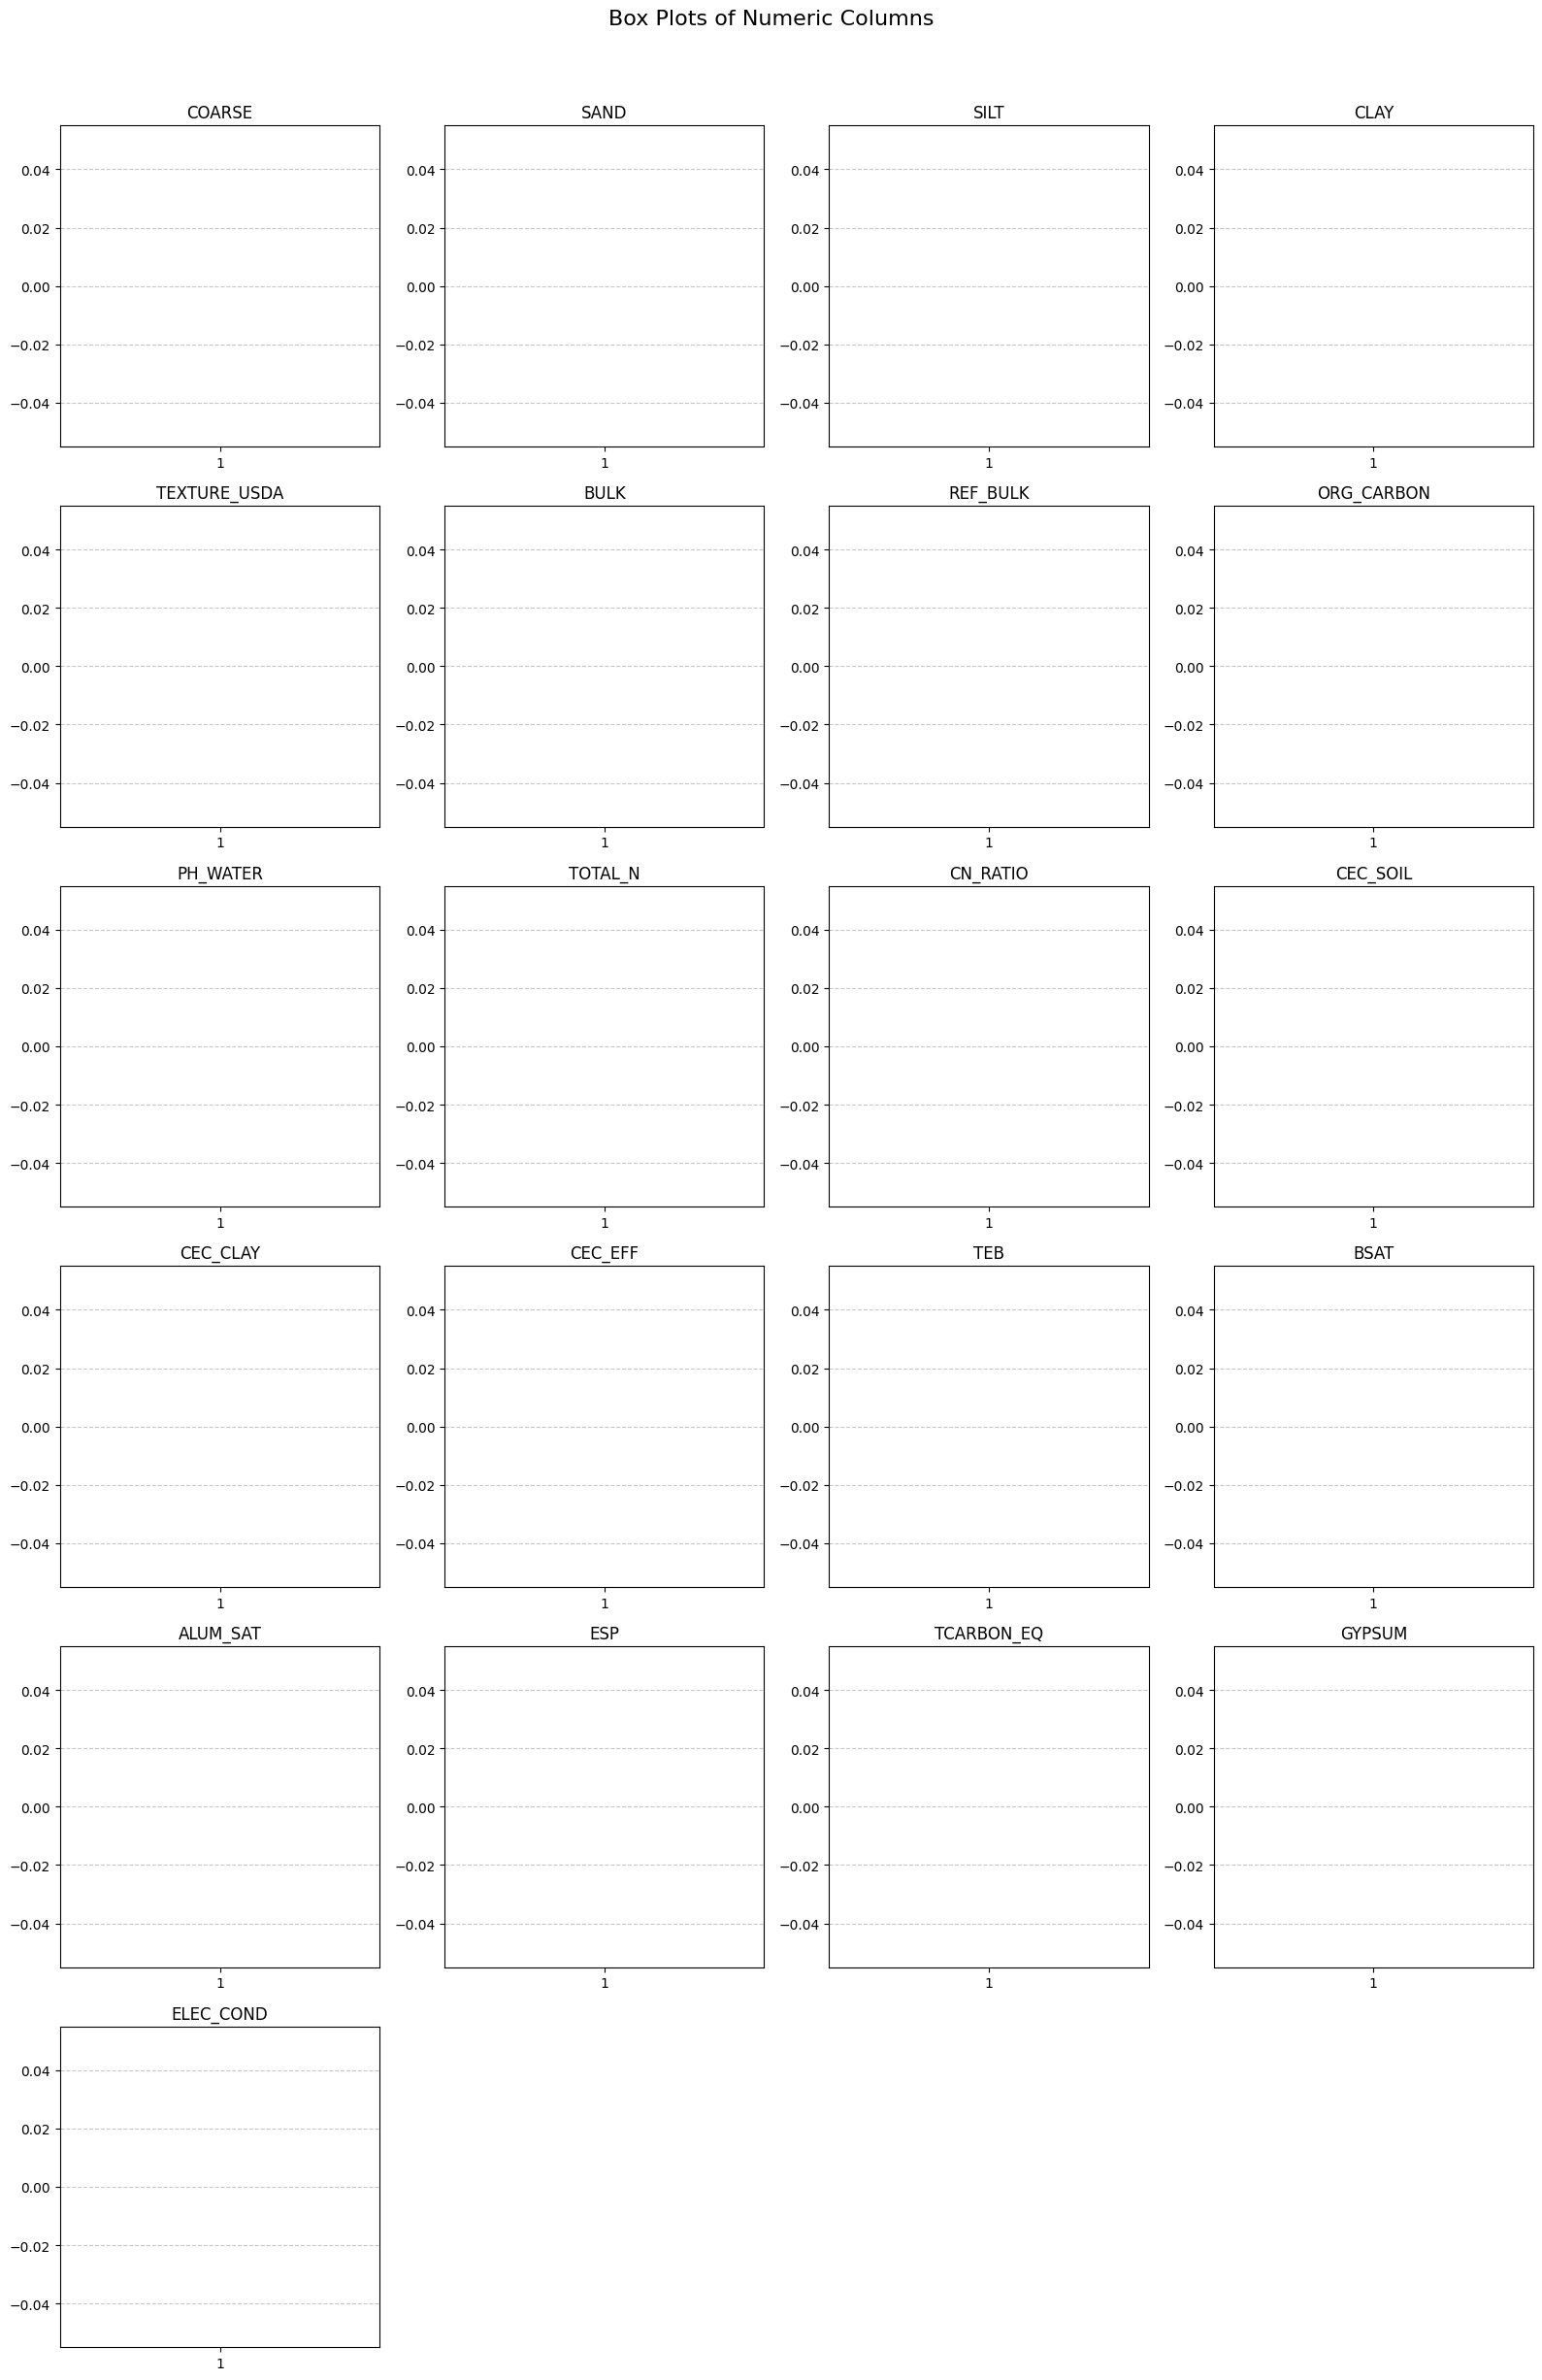

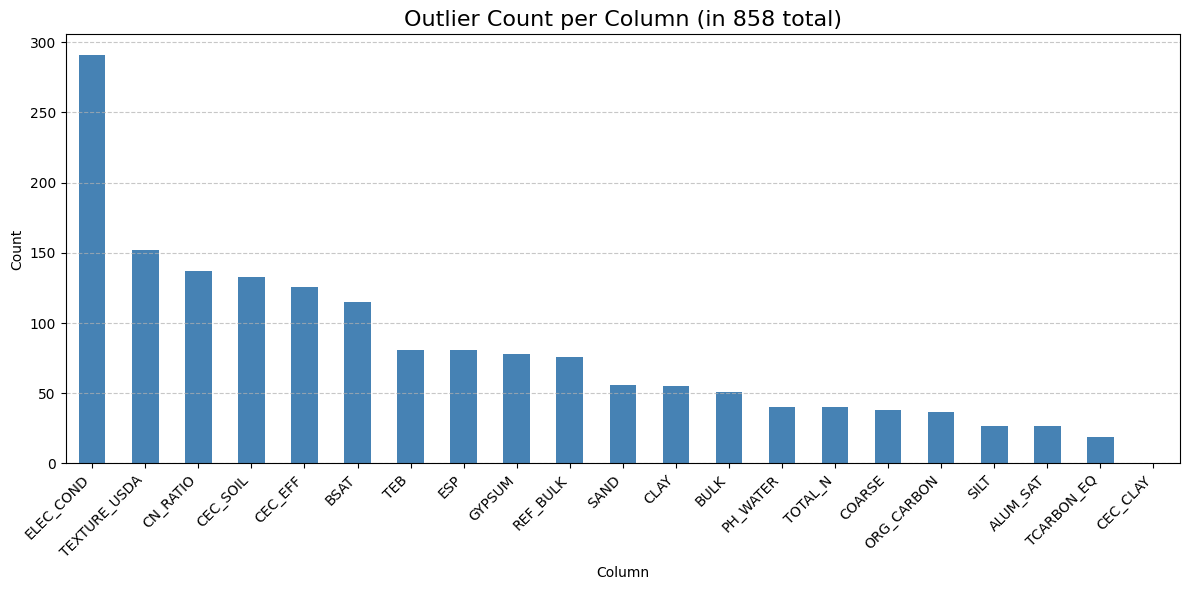

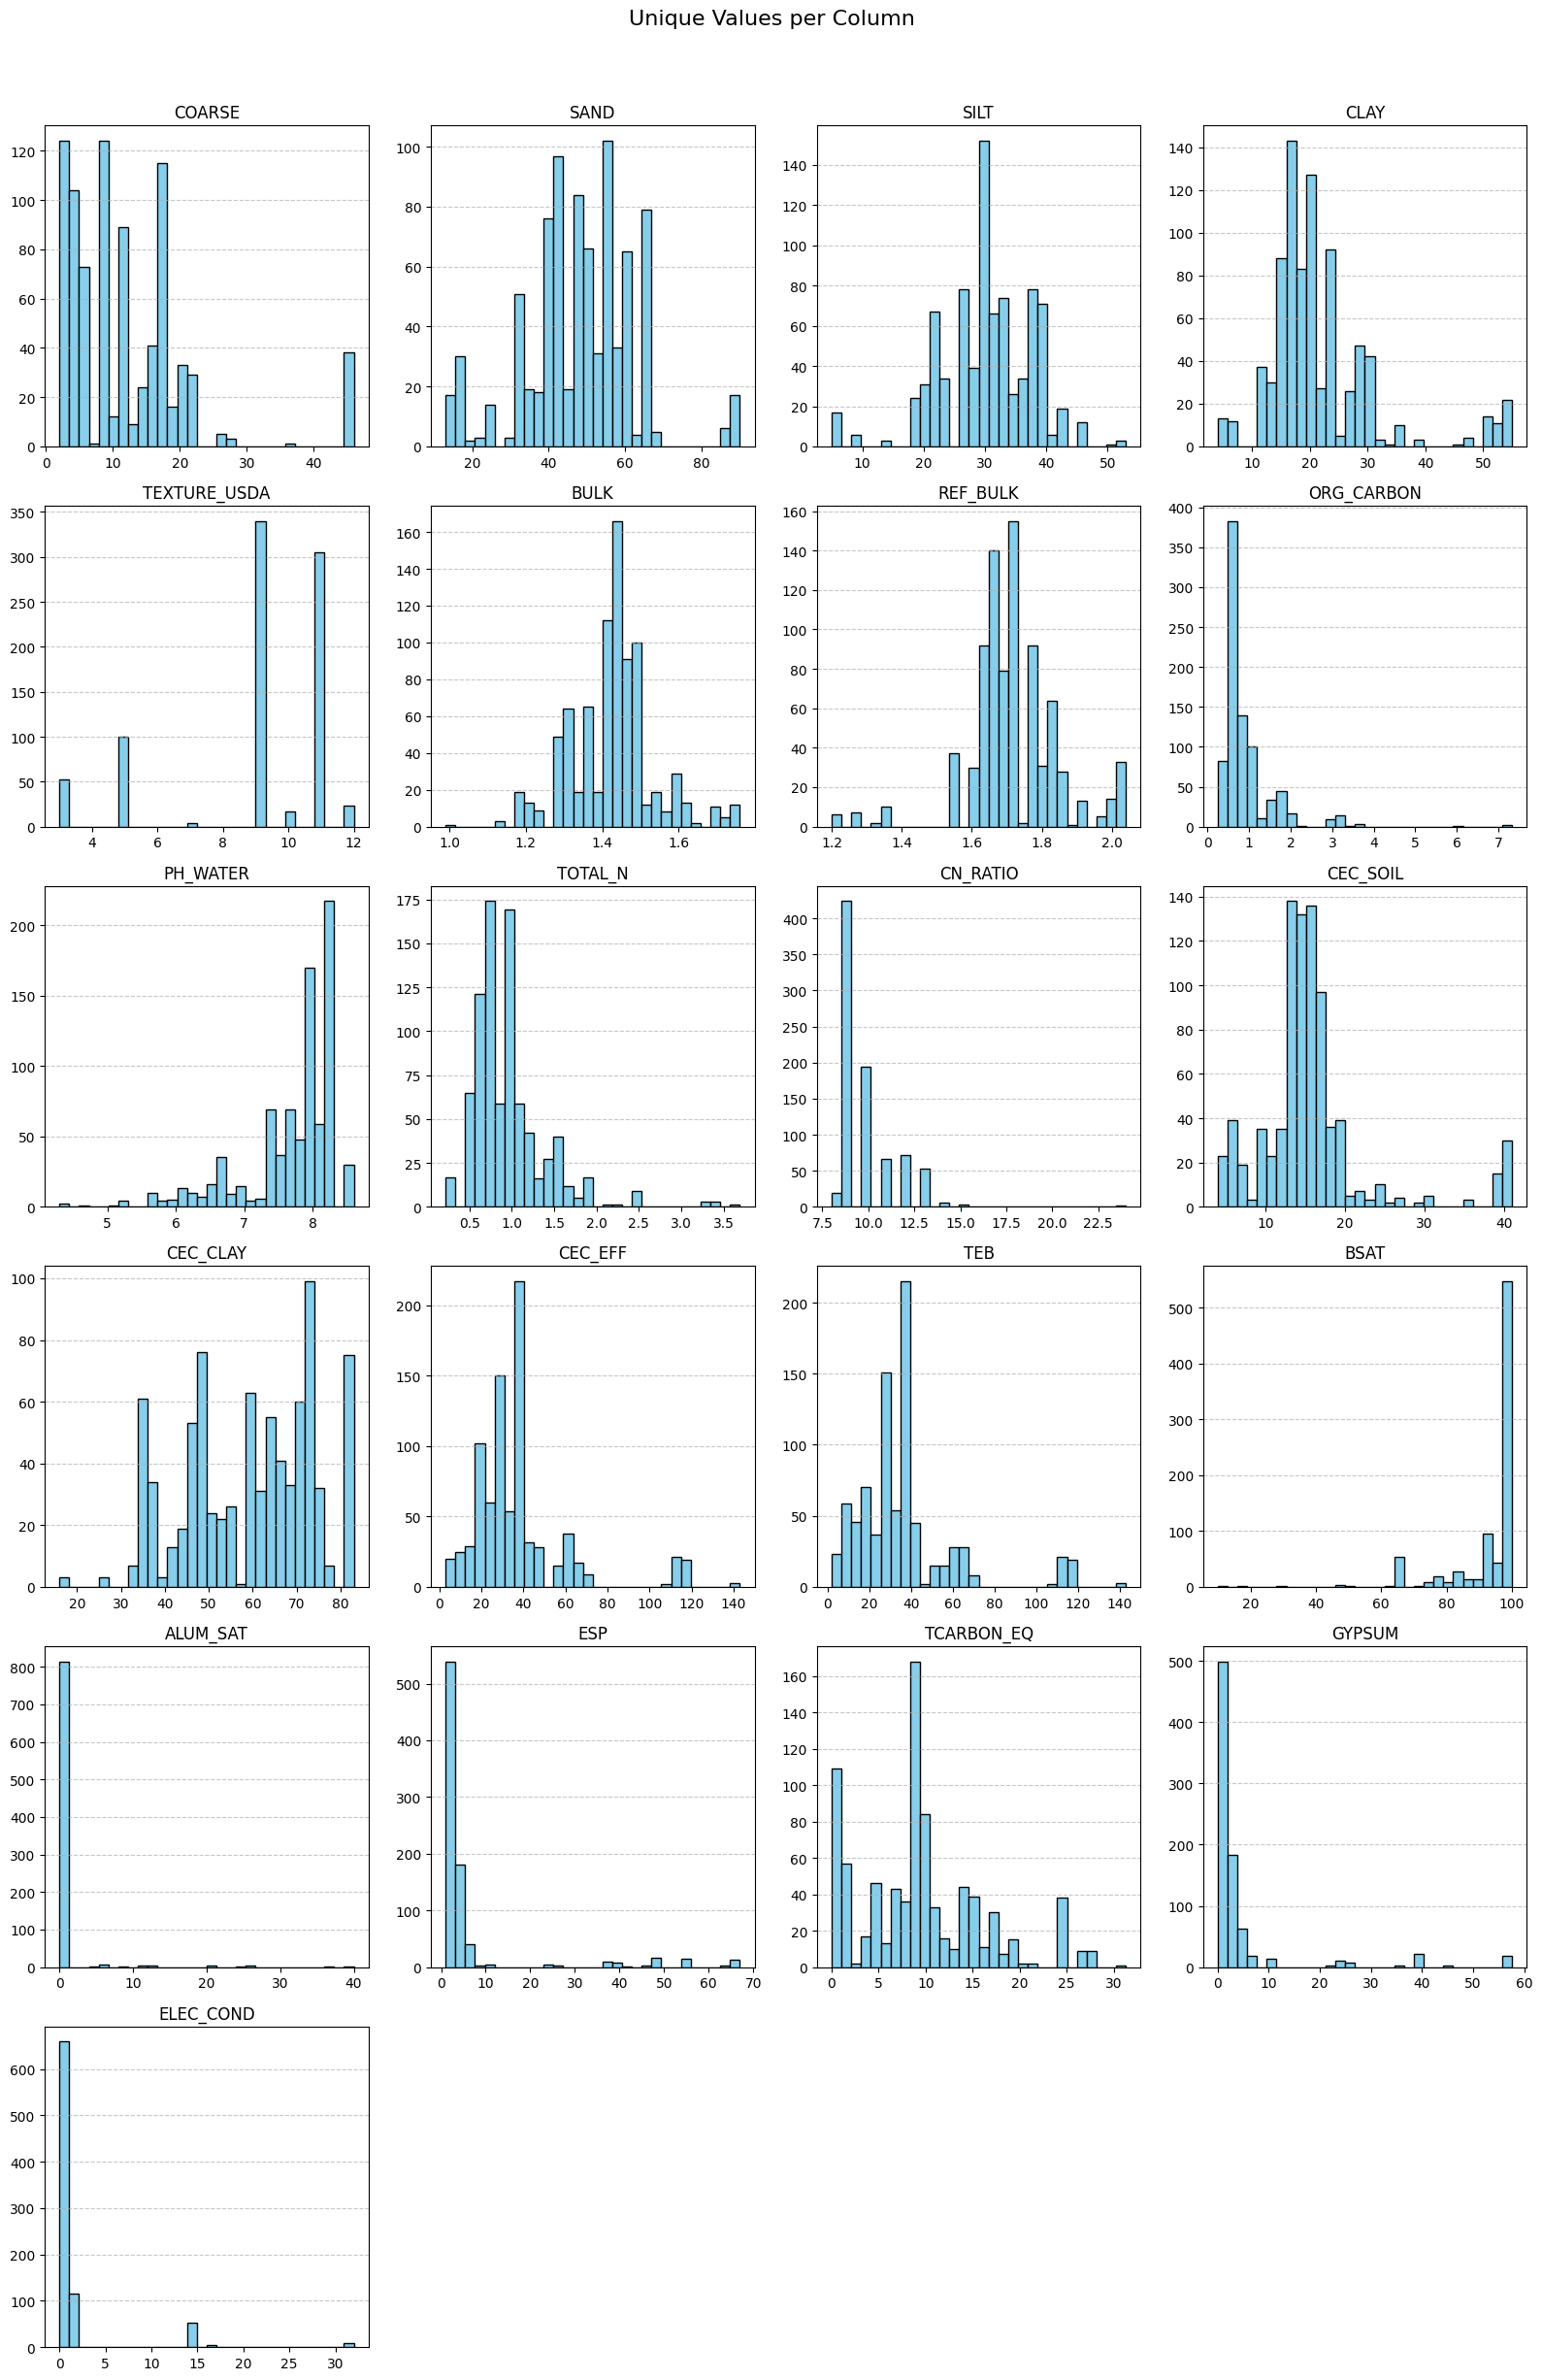

In [91]:

cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_box_plots(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_box_plots(numeric_cols)





Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
outlier_counts = is_outlier.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
outlier_counts.plot(kind="bar", color="steelblue")
plt.title(f"Outlier Count per Column (in {len(numeric_cols)} total)", fontsize=16)
plt.xlabel("Column")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

def plot_histograms(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



plot_histograms(numeric_cols)

# Fixing Outliers and negative values

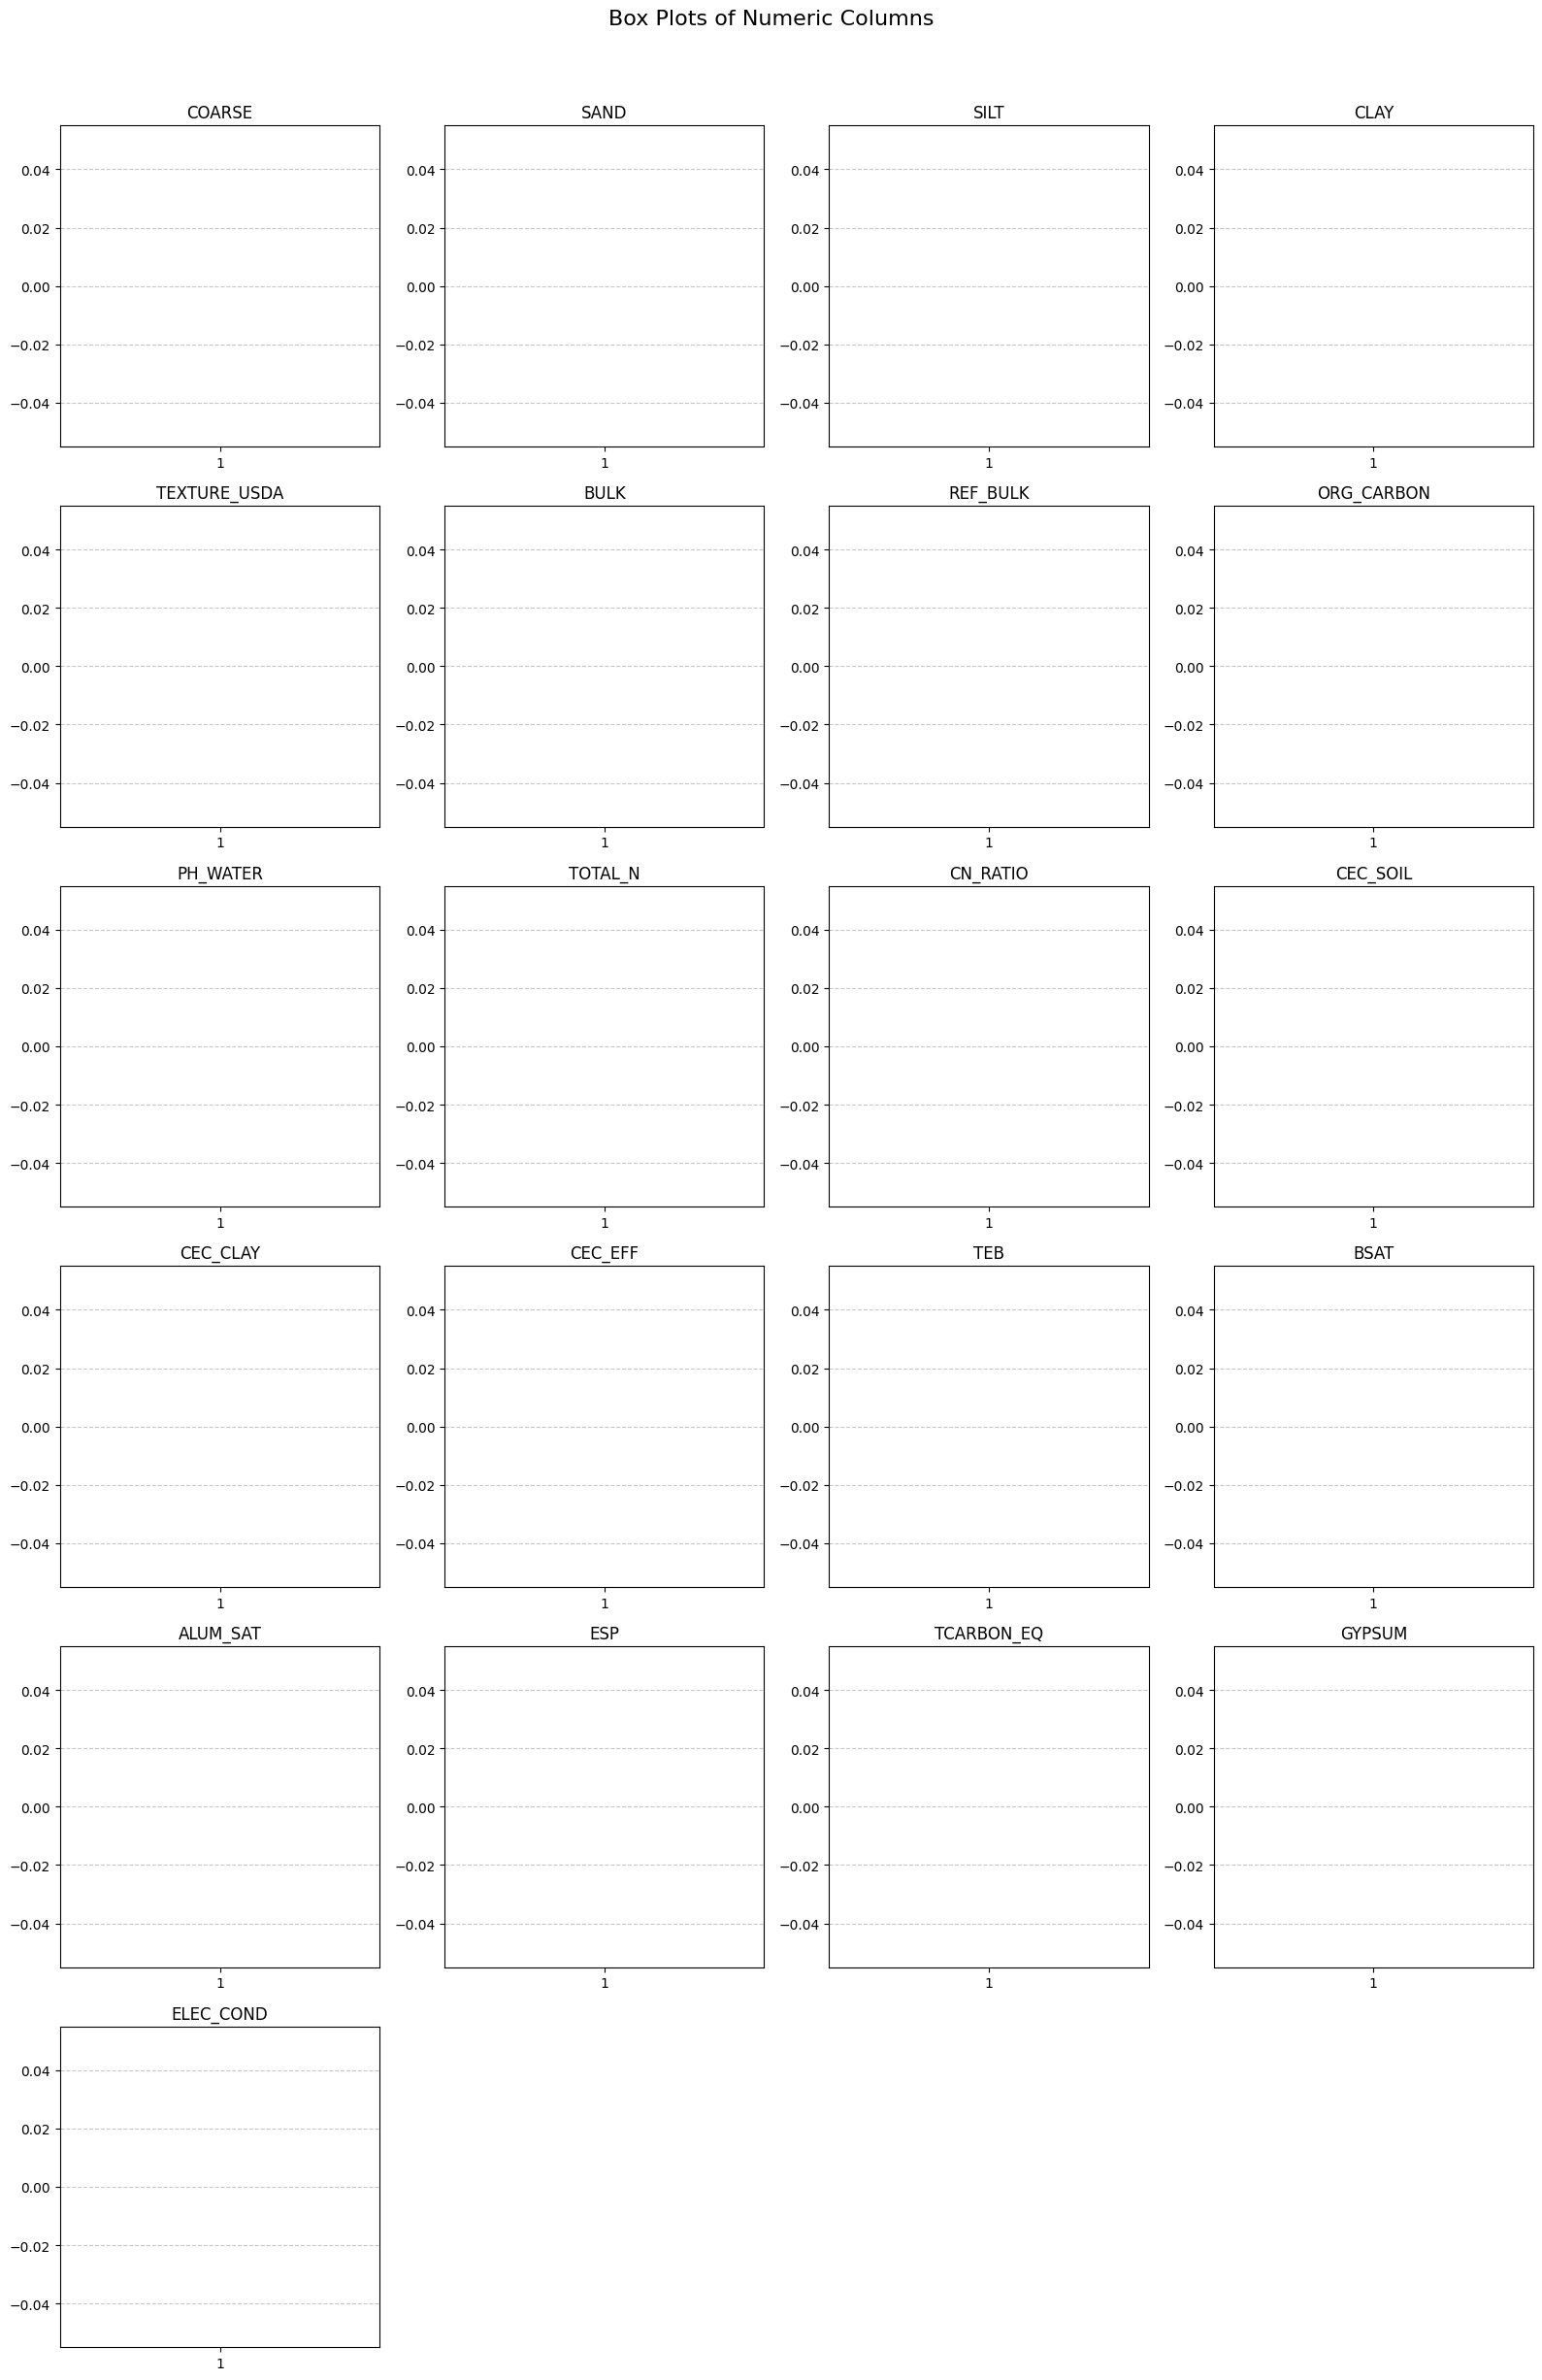

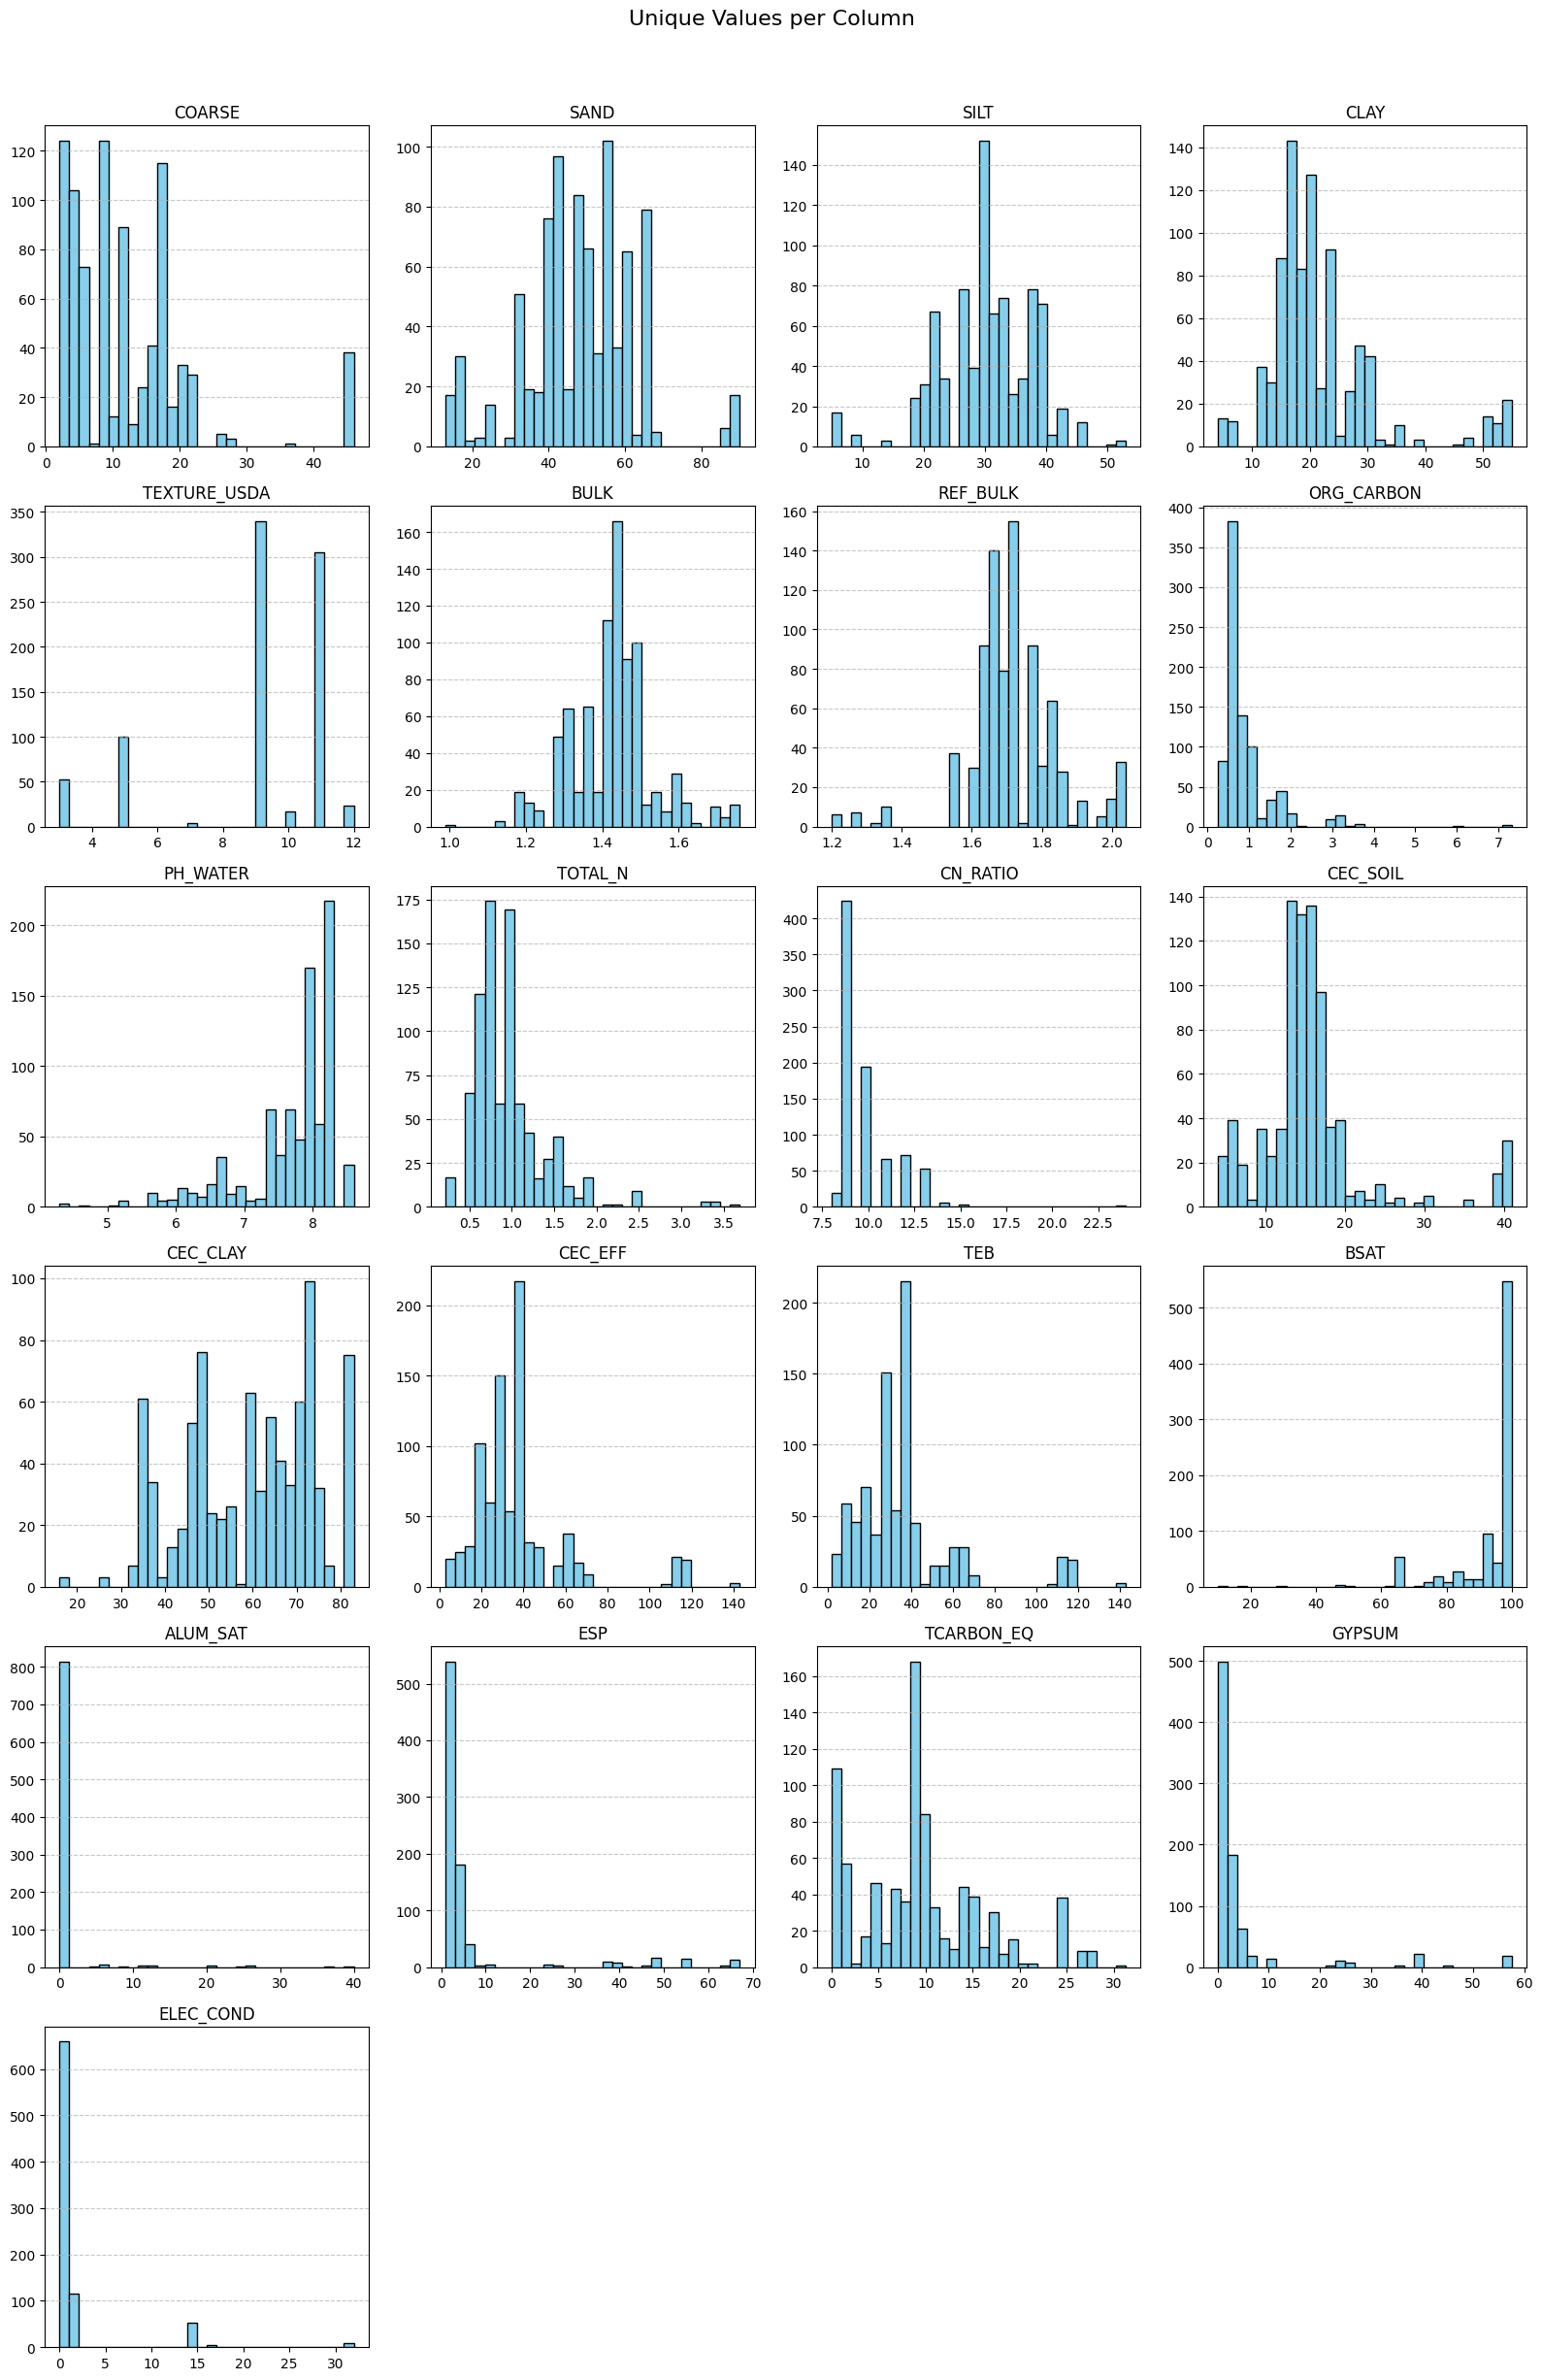

In [92]:
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# numeric_cols = numeric_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)

plot_box_plots(numeric_cols)
plot_histograms(numeric_cols)


# Correlation analysis

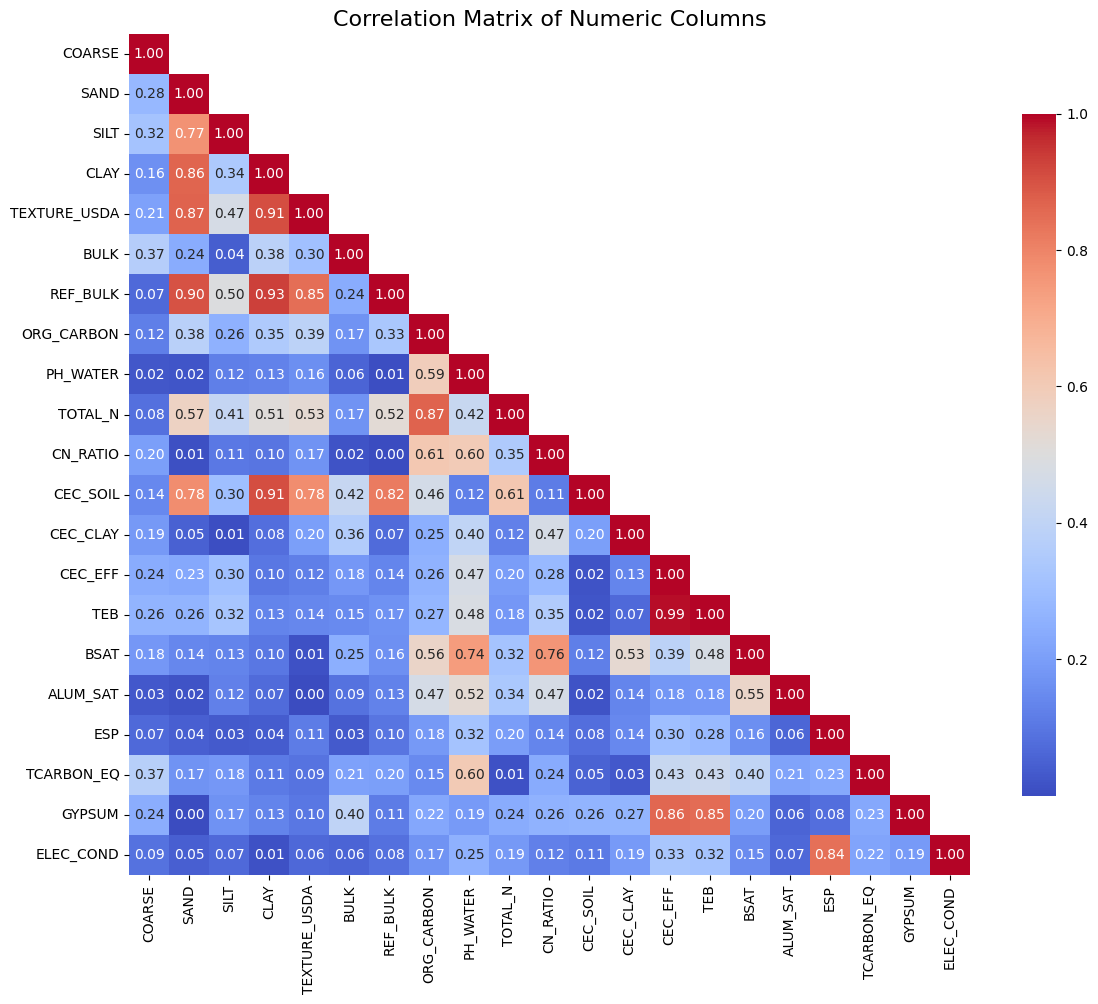

In [93]:

numeric_cols = numeric_cols.loc[:, numeric_cols.nunique() > 1]

# Correlation analysis
correlation_matrix = numeric_cols.corr().abs()

def plot_correlation_matrix(correlation_matrix):
    mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix of Numeric Columns", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(correlation_matrix)

# Remove Correleated Features 

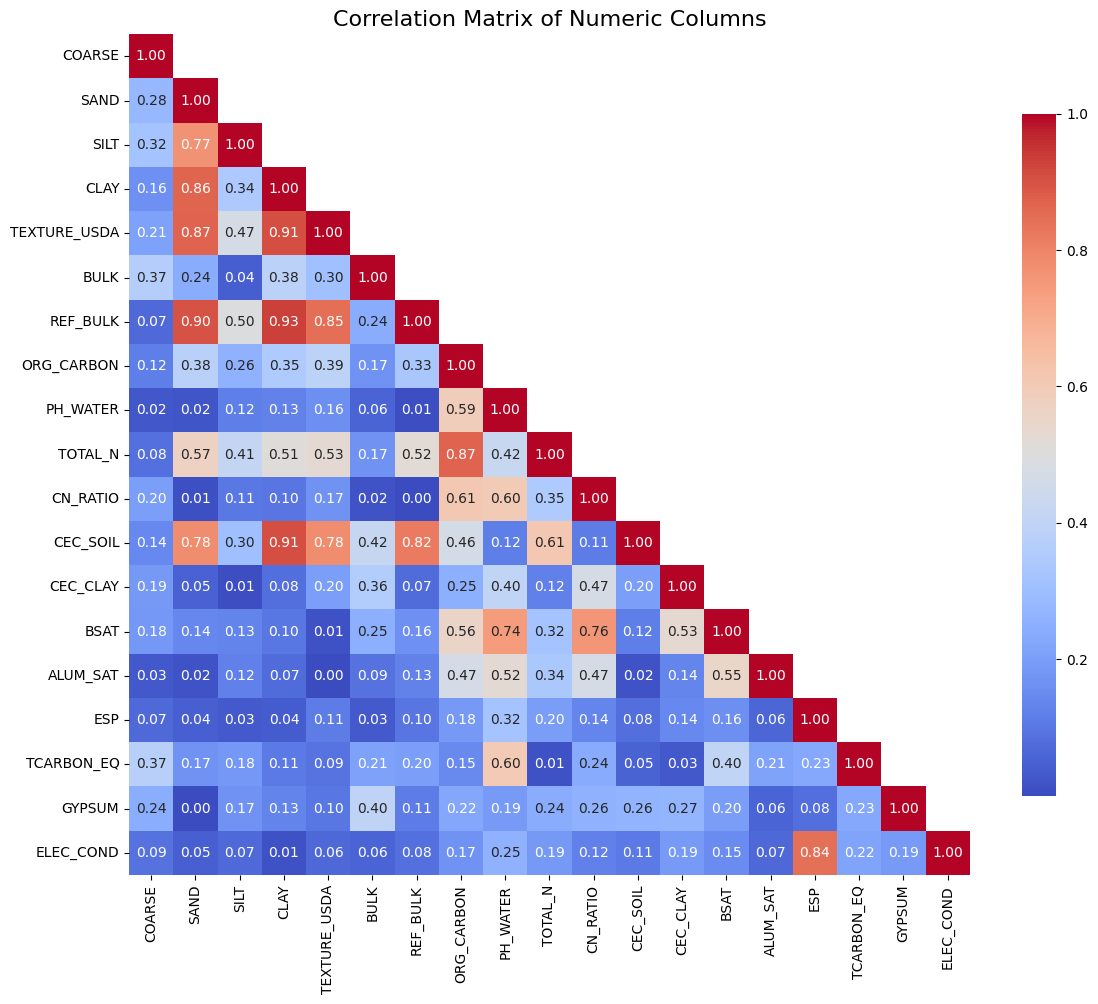

In [94]:
np.fill_diagonal(correlation_matrix.values, 0)
correlated_cols = [col for col in correlation_matrix.columns if any(correlation_matrix[col] > 0.95 )]
new_numeric_cols = numeric_cols.drop(columns=correlated_cols)
plot_correlation_matrix(new_numeric_cols.corr().abs())

# Remerging all columns

In [95]:
all_cols.update(new_numeric_cols)


# Exporting cleaned dataset

In [96]:

# =========================
# ======= EXPORTING =======
# =========================

layers.update(all_cols)
dataset = smu_ids.merge(layers, on="HWSD2_SMU_ID", how="inner")
dataset = dataset.drop(columns=["HWSD2_SMU_ID"])
print("Merging complete.")

dataset.to_parquet(r"../local_dataset/dataset/soil_full.parquet", engine="fastparquet", index=False)
print("Parquet export complete.")

# xarray_dataset_full = xarray.Dataset.from_dataframe(dataset)
# xarray_dataset_full.to_netcdf(r"../local_dataset/dataset/soil_full.nc")
# # print("NetCDF export complete.")

# nc_layers_full = xarray.open_dataset(r"../local_dataset/dataset/soil_full.nc")
# dataset = nc_layers_full.to_dataframe().reset_index(drop=True)

# print(dataset.shape)
# dataset.describe()





C:\Users\pc\AppData\Local\Temp\ipykernel_10340\696494103.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.         11.         11.          7.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          6.          6.          6.          6.          6.
  6.          6.          9.          9.          9.          9.
  9.          9.         11.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 11.         11.         11.         11.         11.         11.
 11.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.         26.
 26.         26.         26.         26

Merging complete.
Parquet export complete.


# Checking the data after export

In [97]:
dataset = pd.read_parquet(r"../local_dataset/dataset/soil_full.parquet", engine="fastparquet")

print("=== Checking the data after export === ")
print("=== Shape === ")
print(dataset.shape)
print("=== Missing Values === ")
print(dataset.isnull().sum())

=== Checking the data after export === 
=== Shape === 
(7109938, 24)
=== Missing Values === 
lon              0
lat              0
COARSE           0
SAND             0
SILT             0
CLAY             0
TEXTURE_USDA     0
TEXTURE_SOTER    0
BULK             0
REF_BULK         0
ORG_CARBON       0
PH_WATER         0
TOTAL_N          0
CN_RATIO         0
CEC_SOIL         0
CEC_CLAY         0
CEC_EFF          0
TEB              0
BSAT             0
ALUM_SAT         0
ESP              0
TCARBON_EQ       0
GYPSUM           0
ELEC_COND        0
dtype: int64
